In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths

import matplotlib.pyplot as plt 
import numpy as np
import os
import cv2

lr = 1e-4
Epochs = 20
BS = 32


In [2]:
data_path = 'dataset'
img_path = list(paths.list_images(data_path))
print(len(img_path))
imgs = []
labels = []

for im in img_path:
    label = im.split(os.path.sep)[-2]
    
    img= load_img(im, target_size=(224, 224))
    img= img_to_array(img)
    img= preprocess_input(img)
    
    imgs.append(img)
    labels.append(label)
    
    

1376


In [3]:
imags = np.array(imgs, dtype='float32')
labels = np.array(labels)

In [4]:
lb = LabelBinarizer()
labels = to_categorical(lb.fit_transform(labels))

In [5]:
print(imags.shape)
print(labels.shape)

(1376, 224, 224, 3)
(1376, 2)


In [6]:
(train_x, test_x, train_y, test_y) = train_test_split(imags, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(1100, 224, 224, 3)
(276, 224, 224, 3)
(1100, 2)
(276, 2)


In [8]:
aug = ImageDataGenerator(rotation_range=30,
                        zoom_range=0.15,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.15,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [11]:
bm = MobileNetV2(weights='imagenet', include_top=False,
                       input_tensor=Input(shape=(224, 224, 3)))
 

In [12]:
hm = bm.output
hm = AveragePooling2D(pool_size=(7,7))(hm)
hm = Flatten()(hm)
hm = Dense(128, activation='relu')(hm)
hm = Dropout(0.5)(hm)
hm = Dense(2, activation='sigmoid')(hm)

model= Model(inputs=bm.input, outputs=hm)

for l in bm.layers:
    l.trainable = False

In [13]:
opt = Adam(lr=lr, decay = lr/Epochs)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [16]:
his = model.fit(aug.flow(train_x, train_y, batch_size=BS),
               steps_per_epoch=(len(train_x)//BS), 
               validation_data=(test_x, test_y),
               validation_steps=(len(test_x) // BS),
               epochs=Epochs)

  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 25s 727ms/step - loss: 0.6139 - accuracy: 0.6512 - val_loss: 0.3996 - val_accuracy: 0.8574
Epoch 2/20
34/34 [==============================] - 9s 272ms/step - loss: 0.4225 - accuracy: 0.8263 - val_loss: 0.2681 - val_accuracy: 0.9336
Epoch 3/20
34/34 [==============================] - 10s 285ms/step - loss: 0.3431 - accuracy: 0.8680 - val_loss: 0.1979 - val_accuracy: 0.9492
Epoch 4/20
34/34 [==============================] - 10s 298ms/step - loss: 0.2778 - accuracy: 0.8947 - val_loss: 0.1451 - val_accuracy: 0.9707
Epoch 5/20
34/34 [==============================] - 9s 273ms/step - loss: 0.2321 - accuracy: 0.9185 - val_loss: 0.1150 - val_accuracy: 0.9746
Epoch 6/20
34/34 [==============================] - 9s 279ms/step - loss: 0.2126 - accuracy: 0.9190 - val_loss: 0.1084 - val_accuracy: 0.9746
Epoch 7/20
34/34 [==============================] - 9s 264ms/step - loss: 0.

In [17]:
predict = model.predict(test_x, batch_size=BS)

predict_ID = np.argmax(predict, axis=1)


print(classification_report(test_y.argmax(axis=1), predict_ID, 
                           target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      1.00      0.99       138
without_mask       1.00      0.97      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



[[138   0]
 [  4 134]]
acc: 0.9855
sensitivity: 1.0000
specificity: 0.9710


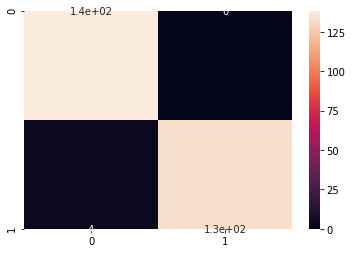

In [19]:
cm = confusion_matrix(test_y.argmax(axis=1), predict_ID)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

import seaborn as sns
sns.heatmap(cm, annot=True)

[INFO] saving COVID-19 detector model...


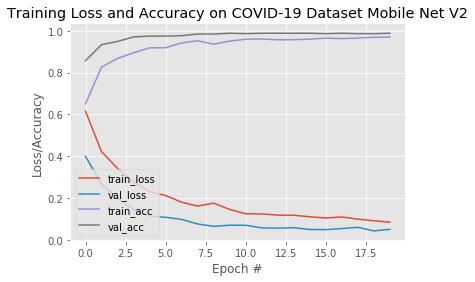

In [21]:
# plot the training loss and accuracy
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), his.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), his.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), his.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), his.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset Mobile Net V2")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save('covid_19_face_mask.h5')